# Import libraries and define functions + Initial setup

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import csv


## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
'''
name: relative_transcript_abundance

purpose: calculate relative transcript abundance

input: a dataframe with a ref_gene_id column identifying the transcript gene of origin and a cov columns with 
the coverage for the transcripts.

output: the same dataframe with a relative abundance column added
'''



def relative_transcript_abundance(df):
    
    ## Group by gene_id and get total expression for each gene (not counting introns)
    df_sums = df[["gene_id", "total_CPM"]].groupby("gene_id").sum()
    df_sums["total_CPM_gene"] = df_sums["total_CPM"]
    df_sums.drop(columns="total_CPM", inplace=True)
    
    ## Merge dataframe with total gene level CPM with regular transcript level CPM dataframe
    merged_df = pd.merge(df, df_sums, how='inner', on="gene_id")
    
    ## Calculater relative percent abundance for each transcript within its gene
    merged_df["relative_abundance_percent"] = ((merged_df["total_CPM"]/merged_df["total_CPM_gene"]) * 100)
    
    ## Rename total_CPM for transcript column
    merged_df["total_CPM_transcript"] = merged_df["total_CPM"]
    merged_df.drop(columns="total_CPM", inplace=True)


    return merged_df

In [3]:
'''
function name: fix_column_names

purpose: Fixing the column names, making them smaller, informative, and consistent

input: The raw counts dataframe for either genes or transcripts 

output: Same dataframe with improved column names
'''

def fix_column_names(df, is_gene=False):
    
    ## Check if this is a gene counts object
    if is_gene:
        
        ## Get count column names and create list of new column names
        count_columns = df.columns.tolist()
        list_new_names = ["gene_id"]
        
        ## gene_id comes in as index for gene counts data, make it into the first column instead
        df["gene_id"] = df.index
        cols = list(df.columns)
        cols = [cols[-1]] + cols[:-1]
        df = df[cols]
        df.reset_index(inplace=True, drop=True)
    
    ## If it is a transcript dataset
    else:
        ## Set count columns and create list of new names
        count_columns = df.columns[2:].tolist()
        list_new_names = [ "transcript_id", "gene_id"]
    
    ## Fix names one by one and add to list of new names
    for col in count_columns:
        col = col.split("_mapped")[0] + "_counts"
        list_new_names.append(col)
    
    ## Rename columns
    df.columns = list_new_names
    
    return df 

In [4]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True, is_transcript=False, is_prot=False, delete_other=True):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("gene_name \"", expand=True)[1].str.split('\";', expand=True)[0]
        
        ## Get get transcript biotype
        df["gene_biotype"] = df["other"].str.split('gene_biotype "', expand=True)[1].str.split('"', expand=True)[0]
        
        ## If is transcript get transcript id and transcript biotype
        if is_transcript:
            df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]
            df["transcript_biotype"] = df["other"].str.split('transcript_biotype "', expand=True)[1].str.split('"', expand=True)[0]
            
            ## If is prot get protein_id
            if is_prot:
                df["protein_id"] = df["other"].str.split('protein_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["ccds_id"] = df["other"].str.split('ccds_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)
        

    else:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Get transcript ids
        df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        if delete_other:
            df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [5]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df, is_gene=False):

    ## Set count columns if dataframe is gene counts
    if is_gene:
        count_columns = df.columns[1:].tolist()
    
    ## Set count columns if dataframe is transcript counts
    else:
        count_columns = df.columns[2:].tolist()

    ## Loop through counts columns to calculate CPM and add to the dataframe
    for col in count_columns:
        
        df[col] = round(df[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        df[cpm_name] = round(((df[col]/(df[col].sum())) * 1000000), 2)
    
    return df  

In [6]:
## define ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

In [7]:
## Define CHM13 protein coding genes

chm13_predicted_protein_coding = ["LOFF_G0000051", "LOFF_G0000054", "LOFF_G0000056", "LOFF_G0000342", "LOFF_G0001069", "LOFF_G0001070", "LOFF_G0001164",
 "LOFF_G0001213", "LOFF_G0001216", "LOFF_G0001232", "LOFF_G0001262", "LOFF_G0001310", "LOFF_G0001311", "LOFF_G0001358",
 "LOFF_G0001362", "LOFF_G0001366", "LOFF_G0001380", "LOFF_G0001381", "LOFF_G0001382", "LOFF_G0001384", "LOFF_G0001386",
 "LOFF_G0001716", "LOFF_G0001824", "LOFF_G0002011", "LOFF_G0002012", "LOFF_G0002013", "LOFF_G0002014", "LOFF_G0002015",
 "LOFF_G0002016", "LOFF_G0002019", "LOFF_G0002020", "LOFF_G0002021", "LOFF_G0002023", "LOFF_G0002038", "LOFF_G0002039",
"LOFF_G0002040", "LOFF_G0002041", "LOFF_G0002043", "LOFF_G0002044", "LOFF_G0002045", "LOFF_G0002047", "LOFF_G0002048",
 "LOFF_G0002049", "LOFF_G0002050", "LOFF_G0002051", "LOFF_G0002052", "LOFF_G0002053", "LOFF_G0002054", "LOFF_G0002055",
 "LOFF_G0002160", "LOFF_G0002169", "LOFF_G0002170", "LOFF_G0002171", "LOFF_G0002172", "LOFF_G0002173", "LOFF_G0002174",
 "LOFF_G0002175", "LOFF_G0002176", "LOFF_G0002177", "LOFF_G0002178", "LOFF_G0002179", "LOFF_G0002184", "LOFF_G0002186",
 "LOFF_G0002187", "LOFF_G0002188", "LOFF_G0002189", "LOFF_G0002190", "LOFF_G0002191", "LOFF_G0002192", "LOFF_G0002193",
 "LOFF_G0002194", "LOFF_G0002195", "LOFF_G0002196", "LOFF_G0002197", "LOFF_G0002198", "LOFF_G0002199", "LOFF_G0002200",
 "LOFF_G0002201", "LOFF_G0002452", "LOFF_G0002485", "LOFF_G0002499", "LOFF_G0002508", "LOFF_G0002509", "LOFF_G0002530",
 "LOFF_G0002531", "LOFF_G0002532", "LOFF_G0002566", "LOFF_G0002706", "LOFF_G0002709", "LOFF_G0002798", "LOFF_G0002923",
"LOFF_G0002924", "LOFF_G0002925", "LOFF_G0002926", "LOFF_G0002927", "LOFF_G0002928", "LOFF_G0002929", "LOFF_G0002930",
 "LOFF_G0002931"]


## - Import data and pre-process it

In [8]:
## Open counts matrices

df = pd.read_csv("../../../data/raw/1st_rebuttal_data/OURS_CHM13_quant/bambu_quant/counts_transcript.txt",
                sep="\t")

df_unique = pd.read_csv("../../../data/raw/1st_rebuttal_data/OURS_CHM13_quant/bambu_quant/fullLengthCounts_transcript.txt",
                sep="\t")

df_full = pd.read_csv("../../../data/raw/1st_rebuttal_data/OURS_CHM13_quant/bambu_quant/uniqueCounts_transcript.txt",
                sep="\t")

In [9]:
## Fix column names

df = fix_column_names(df, is_gene=False)

df_unique = fix_column_names(df_unique, is_gene=False)

df_full = fix_column_names(df_full, is_gene=False)

In [10]:
## Calculate total counts

df["total_counts"] = df[df.columns[2:].to_list()].sum(axis=1)

df_unique["total_counts"] = df_unique[df_unique.columns[2:].to_list()].sum(axis=1)

df_full["total_counts"] = df_full[df_full.columns[2:].to_list()].sum(axis=1)

In [11]:
## Calculate CPM for normal df

df_cpm = calculate_cpm(df.copy(), is_gene=False)

df_cpm.drop(columns=df_cpm.filter(regex='counts').columns, inplace=True)

In [12]:
## Calculate median counts/CPM

df["median_counts"] = df[df.filter(regex='[0-9]_counts').columns].median(axis=1)

df_cpm["median_CPM"] = df_cpm[df_cpm.filter(regex='[0-9]_CPM').columns].median(axis=1)

df_unique["median_counts"] = df_unique[df_unique.filter(regex='[0-9]_counts').columns].median(axis=1)

df_full["median_counts"] = df_full[df_full.filter(regex='[0-9]_counts').columns].median(axis=1)

In [13]:
## Only keep the relevant new genes

df = df.loc[df["gene_id"].str.contains("\(")].copy()
df["gene_id"] = df["gene_id"].str.split("(", expand=True)[1].str.split(")", expand=True)[0]
df.dropna(subset="gene_id", inplace=True)

df_cpm = df_cpm.loc[df_cpm["gene_id"].str.contains("\(")].copy()
df_cpm["gene_id"] = df_cpm["gene_id"].str.split("(", expand=True)[1].str.split(")", expand=True)[0]
df_cpm.dropna(subset="gene_id", inplace=True)

df_unique = df_unique.loc[df_unique["gene_id"].str.contains("\(")].copy()
df_unique["gene_id"] = df_unique["gene_id"].str.split("(", expand=True)[1].str.split(")", expand=True)[0]
df_unique.dropna(subset="gene_id", inplace=True)

df_full = df_full.loc[df_full["gene_id"].str.contains("\(")].copy()
df_full["gene_id"] = df_full["gene_id"].str.split("(", expand=True)[1].str.split(")", expand=True)[0]
df_full.dropna(subset="gene_id", inplace=True)

In [14]:
## Only keep relevant CHM13 genes

df = df.loc[df["gene_id"].isin(chm13_predicted_protein_coding)].copy()

df_cpm = df_cpm.loc[df_cpm["gene_id"].isin(chm13_predicted_protein_coding)].copy()

df_unique = df_unique.loc[df_unique["gene_id"].isin(chm13_predicted_protein_coding)].copy()

df_full = df_full.loc[df_full["gene_id"].isin(chm13_predicted_protein_coding)].copy()

In [15]:
## Open CHM13 reference and parse

ref = pd.read_csv("../../../data/raw/1st_rebuttal_data/OURS_CHM13_quant/bambu_quant/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

ref = ref.loc[~ref["chr"].str.startswith("ERCC-")]

ref = parse_df_columns(ref, is_ref=False)

ref_transcripts = ref.loc[ref["type"] == "transcript"].copy()

ref_transcripts = ref_transcripts[["transcript_id", "chr"]].copy()

In [16]:
## Add chromosome

df = df.merge(ref_transcripts, on="transcript_id", how="inner")

df_cpm = df_cpm.merge(ref_transcripts, on="transcript_id", how="inner")

df_unique = df_unique.merge(ref_transcripts, on="transcript_id", how="inner")

df_full = df_full.merge(ref_transcripts, on="transcript_id", how="inner")

In [17]:
## Make chromosome the first column

df = df[[df.columns[-1]] + list(df.columns[:-1])]

df_cpm = df_cpm[[df_cpm.columns[-1]] + list(df_cpm.columns[:-1])]

df_unique = df_unique[[df_unique.columns[-1]] + list(df_unique.columns[:-1])]

df_full = df_full[[df_full.columns[-1]] + list(df_full.columns[:-1])]

In [18]:
## Make final output file

df2 = df[["chr", "gene_id", "transcript_id", "total_counts"]].copy()
df2.columns = ["chr", "gene_id", "transcript_id", "total_counts_ALL"]

df_unique2 = df_unique[["chr", "gene_id", "transcript_id", "total_counts"]].copy()
df_unique2.columns = ["chr", "gene_id", "transcript_id", "total_counts_UNIQUE"]

df_full2 = df_full[["chr", "gene_id", "transcript_id", "total_counts"]].copy()
df_full2.columns = ["chr", "gene_id", "transcript_id", "total_counts_FULL-LENGTH"]

df_merged = df2.merge(df_unique2, on=["chr", "gene_id", "transcript_id"], how="inner")
df_merged = df_merged.merge(df_full2, on=["chr", "gene_id", "transcript_id"], how="inner")

df_merged["transcript_id"] = df_merged["transcript_id"].str.split("(", expand=True)[1].str.split(")", expand=True)[0]

df_merged.to_csv("../../../data/processed/1st_rebuttal/CHM13_new_genes/CHM13_new_prot_counts.tsv")

## - Make Graphs

In [19]:
## Create lists for graph
list_num_all = []
list_num_unique = []
list_num_full = []
list_threshold = []

for i in range(0, 101):
    
    num_all = df.loc[df["total_counts"] >= i].shape[0]
    num_unique = df_unique.loc[df_unique["total_counts"] >= i].shape[0]
    num_full = df_full.loc[df_full["total_counts"] >= i].shape[0]
    
    
    list_num_all.append(num_all)
    list_num_unique.append(num_unique)
    list_num_full.append(num_full)
    list_threshold.append(i)

In [20]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)

# figure size in millimiters
rcParams['figure.figsize'] = (170*mm, 90*mm)
rcParams.update({'font.size': 7})
rcParams['axes.linewidth'] = 1

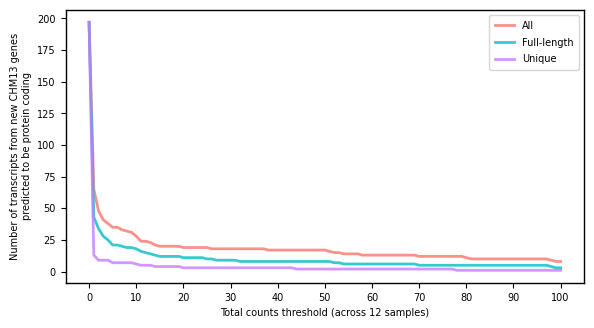

In [27]:
## Make plot showing number of transcripts across CPM thresholds

plt.plot(list_threshold, list_num_all, color=ggplot2_colors[0], label="All", linewidth=2, alpha=0.8)
plt.plot(list_threshold, list_num_full, color=ggplot2_colors[4], label="Full-length", linewidth=2, alpha=0.8)
plt.plot(list_threshold, list_num_unique, color=ggplot2_colors[6], label="Unique", linewidth=2, alpha=0.8)


plt.xticks(np.arange(0, 101, 10))
plt.xlabel('Total counts threshold (across 12 samples)')
plt.ylabel('Number of transcripts from new CHM13 genes\npredicted to be protein coding')
plt.legend(loc="upper right", fontsize=7, borderpad=0.6, labelspacing=0.7)

plt.savefig('../../../figures/1st_rebuttal_figures/CHM13_new_genes/lineplot_CHM13_new_prot_genes.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

In [22]:
data = {"Counts": [list_num_all[0], list_num_all[1], list_num_all[5], list_num_all[10], list_num_all[25], list_num_all[50],
                  list_num_all[100], list_num_unique[0], list_num_unique[1], list_num_unique[5], list_num_unique[10], list_num_unique[25],
                  list_num_unique[50], list_num_full[100], list_num_full[0], list_num_full[1], list_num_full[5], list_num_full[10],
                  list_num_full[25], list_num_full[50], list_num_full[100]],
       "Type of counts": ["All", "All", "All", "All", "All", "All", "All", "Unique", "Unique", "Unique", "Unique",
                        "Unique", "Unique", "Unique", "Full-length", "Full-length", "Full-length", "Full-length",
                          "Full-length", "Full-length", "Full-length"],
       
       "Counts threshold": ["≥ 0", "≥ 1", "≥ 5", "≥ 10", "≥ 25", "≥ 50", "≥ 100",
                          "≥ 0", "≥ 1", "≥ 5", "≥ 10", "≥ 25", "≥ 50", "≥ 100",
                          "≥ 0", "≥ 1", "≥ 5", "≥ 10", "≥ 25", "≥ 50", "≥ 100"]}

df_counts_plot = pd.DataFrame(data=data)

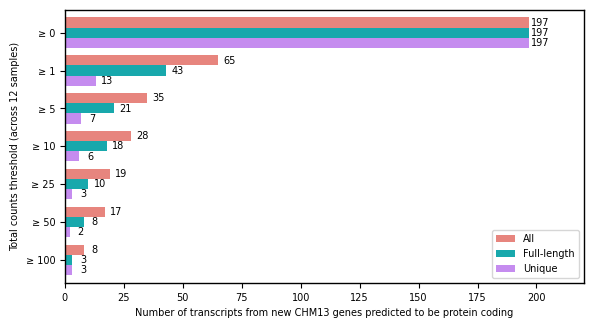

In [26]:
custom_palette = {"All": ggplot2_colors[0], "Unique":  ggplot2_colors[6], "Full-length": ggplot2_colors[4]}



ax = sns.barplot(data=df_counts_plot, x="Counts", y="Counts threshold", hue="Type of counts", orient="h",
            palette=custom_palette,
                  hue_order=["Unique", "Full-length",  "All"],
                  order=["≥ 100", "≥ 50", "≥ 25", "≥ 10", "≥ 5", "≥ 1", "≥ 0"])

plt.xlim(0,220)
plt.ylim(-0.6, 6.6)

ax.set_xlabel("Number of transcripts from new CHM13 genes predicted to be protein coding")
ax.set_ylabel("Total counts threshold (across 12 samples)")

## Adding labels to each bar
for p in ax.patches:
    
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_x() + p.get_width(), p.get_y() + p.get_height()/2), 
                ha='center', va='center', 
                xytext=(8, 0), 
                textcoords='offset points',
                fontsize=7)


handles, labels = ax.get_legend_handles_labels()

# Desired order
order = [2, 1, 0]  # This switches the order to ["B", "A"]

# Remove the current legend
ax.legend_.remove()

# Add a new legend with the desired order
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc="lower right")

plt.savefig('../../../figures/1st_rebuttal_figures/CHM13_new_genes/barplot_CHM13_new_prot_genes.pdf',
            dpi=600, transparent=True, bbox_inches="tight")